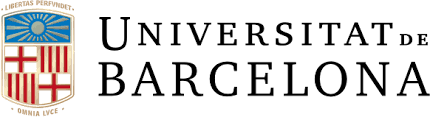

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training_Bin'
test_dir = '/content/drive/MyDrive/Testing_Bin'

In [4]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [5]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 4570 files for training.


In [6]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 1142 files for validation.


In [7]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['Notumor', 'Tumor']


## Desbalance en el Dataset

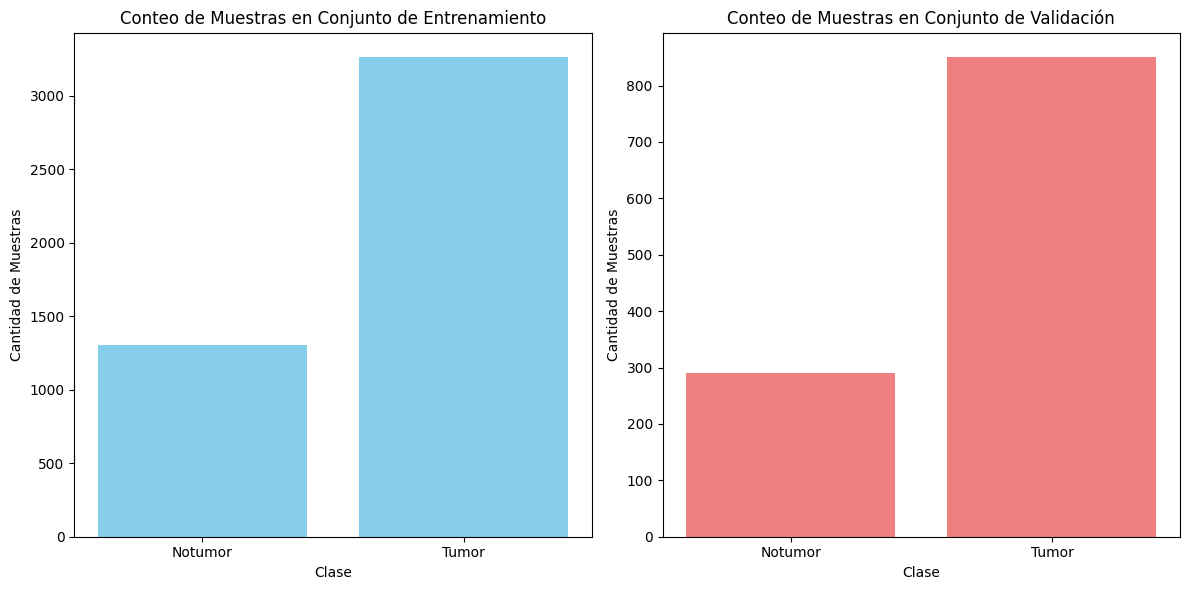

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Obtener las etiquetas de las clases
class_names = train_ds.class_names

# Contar las muestras en el conjunto de entrenamiento
conteo_train = [0] * len(class_names)
for _, labels in train_ds:
    for label in labels.numpy():
        conteo_train[label] += 1

# Contar las muestras en el conjunto de validación
conteo_val = [0] * len(class_names)
for _, labels in val_ds:
    for label in labels.numpy():
        conteo_val[label] += 1

# Crear gráficos de barras para el conjunto de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(class_names, conteo_train, color='skyblue')
plt.title('Conteo de Muestras en Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Muestras')

plt.subplot(1, 2, 2)
plt.bar(class_names, conteo_val, color='lightcoral')
plt.title('Conteo de Muestras en Conjunto de Validación')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Muestras')

plt.tight_layout()
plt.show()


Notese como hay un desbalance claro en el dataset. La clase Tumor tiene muchas mas muestras que la clse Notumor.

**Visualizacion de algunas imagenes**

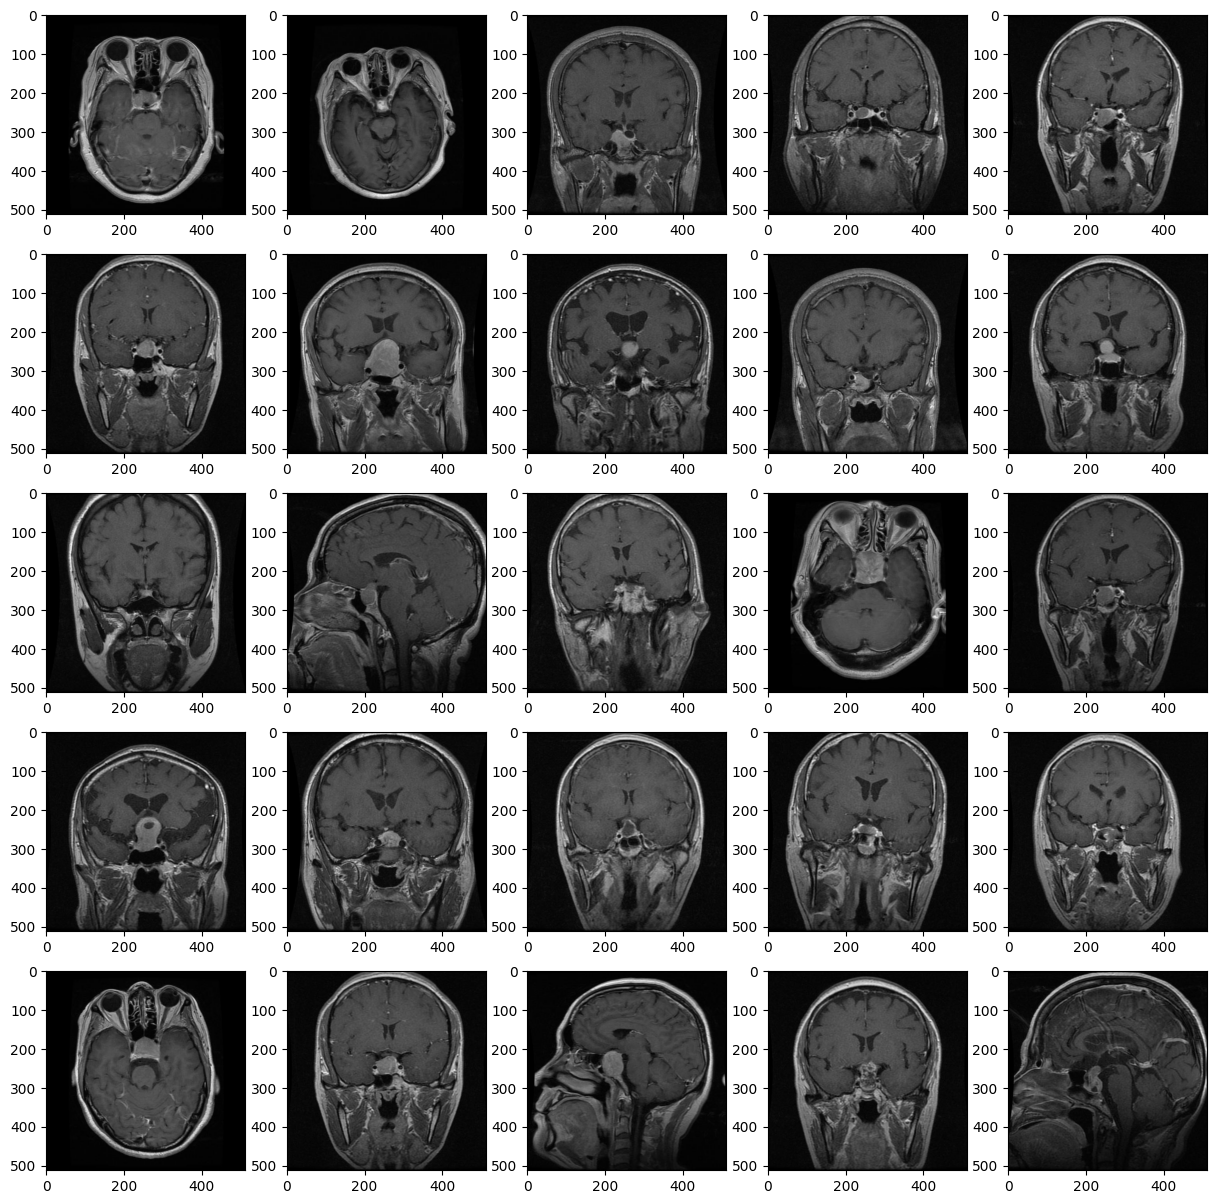

In [ ]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Tumor'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training_Bin/Tumor'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [ ]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

  ]
)

**Visualizacion de Imagenes despues de Data Augmentation**

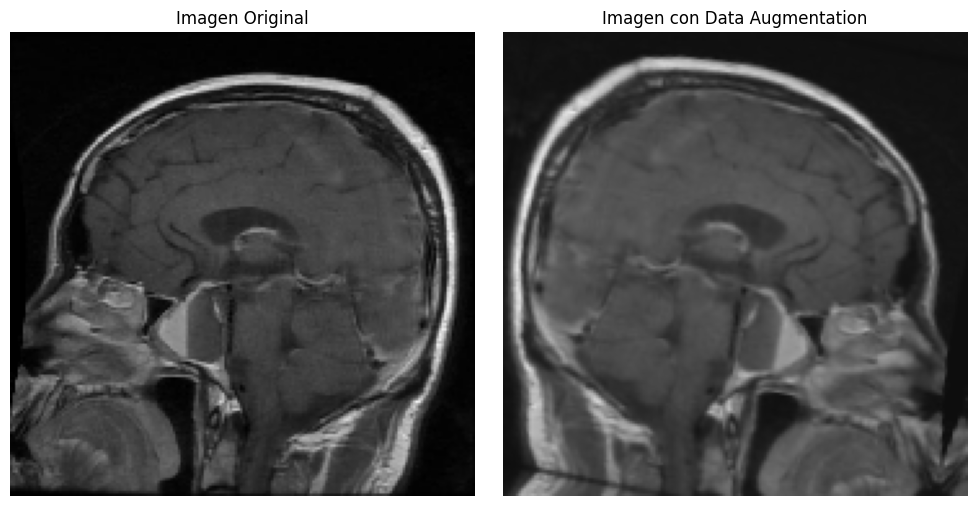

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config

# Habilitar el comportamiento de numpy en TensorFlow
np_config.enable_numpy_behavior()

# Obtener una imagen al azar del conjunto de entrenamiento
random_class = random.choice(class_names)
random_class_dir = os.path.join(train_dir, random_class)
random_image_path = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image_path)

# Cargar la imagen original y redimensionarla
image = load_img(image_path, target_size=(img_height, img_width))
image_array = img_to_array(image)

# Aplicar data augmentation a la imagen
augmented_image_array = data_augmentation(np.expand_dims(image_array, 0))
augmented_image = augmented_image_array[0]

# Normalizar los valores de píxeles al rango [0, 1]
image_array /= 255.0
augmented_image /= 255.0

# Mostrar la imagen original y la imagen con data augmentation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array)
axes[0].set_title("Imagen Original")
axes[0].axis("off")
axes[1].imshow(augmented_image)
axes[1].set_title("Imagen con Data Augmentation")
axes[1].axis("off")

plt.tight_layout()
plt.show()





**Resumen de Transformaciones usadas durante Data Augmentation**

In [ ]:
print(data_augmentation.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 180, 180, 3)      0         
 ightness)                                                       
                                                        

# Entrenamiento del Modelo

In [ ]:
# Cracion del modelo con Redes Neuronales Convolucionales (CNN)
num_classes = len(class_names)#2 clases

from tensorflow.keras.layers import Dropout

model_with_dropout = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Capa de dropout
    layers.Dense(num_classes)
])



In [ ]:
# Compilar
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.001  # Nueva tasa de aprendizaje
optimizer_with_new_lr = Adam(learning_rate=new_learning_rate)

model_with_dropout.compile(optimizer=optimizer_with_new_lr,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])



Importante tener en cuenta que el algortimo optimiza la funcion de perdida durante el entrenamiento para guiar al modelo hacia convergencia, sin embargo la metrica no se optimiza. La metrica funciona para evaluar al modelo despues del entrenamiento**

In [ ]:
model_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [ ]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNN_Bin.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

## Verificamos si hay una GPU Disponible para entrenar nuestro modelo

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Configura la GPU para el crecimiento de la memoria si es necesario
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    # Imprime información sobre las GPUs disponibles
    print("GPU(s) disponibles:")
    for gpu in gpus:
        print(gpu)
else:
    print("No se encontraron GPUs.")


Physical devices cannot be modified after being initialized
GPU(s) disponibles:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
epochs = 30
history = model_with_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNNv_Bin.h5" en el directorio actual
model_with_dropout.save("TFM_CNNv_Bin.h5")

Epoch 1/30
143/143 [==============================] - 910s 1s/step - loss: 0.5709 - accuracy: 0.7442 - val_loss: 0.2576 - val_accuracy: 0.9002
Epoch 2/30
143/143 [==============================] - 6s 41ms/step - loss: 0.2692 - accuracy: 0.9009 - val_loss: 0.1971 - val_accuracy: 0.9361
Epoch 3/30
143/143 [==============================] - 4s 31ms/step - loss: 0.2113 - accuracy: 0.9333 - val_loss: 0.1503 - val_accuracy: 0.9501
Epoch 4/30
143/143 [==============================] - 5s 33ms/step - loss: 0.1910 - accuracy: 0.9376 - val_loss: 0.1398 - val_accuracy: 0.9466
Epoch 5/30
143/143 [==============================] - 5s 32ms/step - loss: 0.1670 - accuracy: 0.9442 - val_loss: 0.1472 - val_accuracy: 0.9475
Epoch 6/30
143/143 [==============================] - 4s 31ms/step - loss: 0.1538 - accuracy: 0.9488 - val_loss: 0.1327 - val_accuracy: 0.9536
Epoch 7/30
143/143 [==============================] - 5s 33ms/step - loss: 0.1447 - accuracy: 0.9514 - val_loss: 0.1233 - val_accuracy: 0.9580

# Curvas de Rendimiento

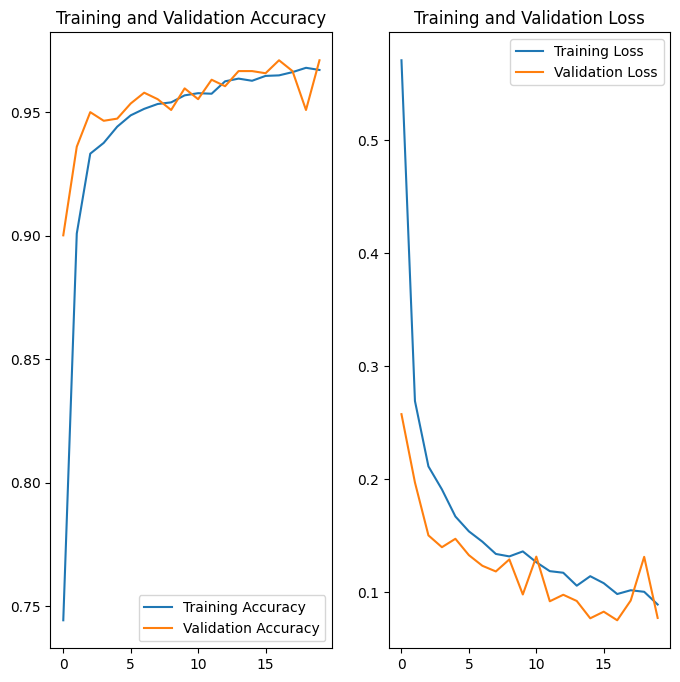

In [ ]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Obtener las etiquetas reales del conjunto de pruebas
y_test_actual = np.array([])
for _, y in val_ds:
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))


1/1 [==============================] - 0s 134ms/step


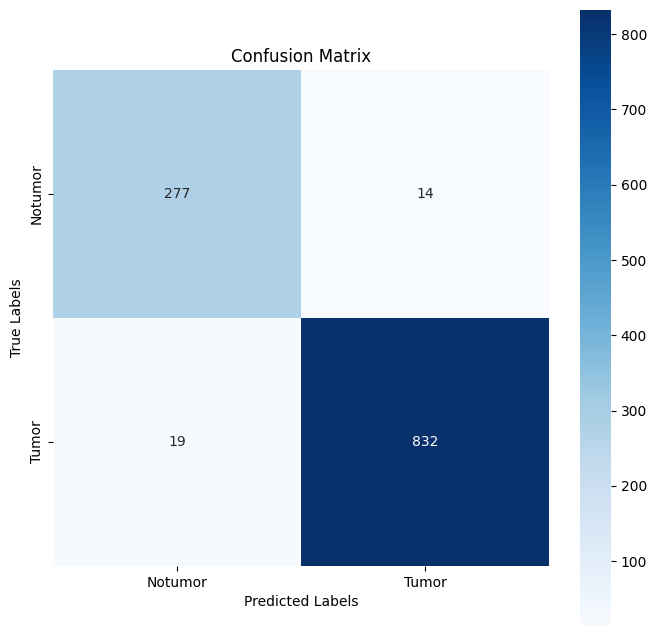

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar predicciones en el conjunto de pruebas
y_pred_actual = np.array([])
for x, _ in val_ds:
    predictions = model_with_dropout.predict(x)
    normalized_predictions = tf.nn.softmax(predictions)  # Aplicacion de softmax para obtener probabilidades
    y_pred = np.argmax(normalized_predictions, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

# matriz de confusión
conf_matrix = confusion_matrix(y_test_actual, y_pred_actual)

# Visualizacion de la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()




In [ ]:
from sklearn.metrics import classification_report

# Obtener el informe de clasificación
report = classification_report(y_test_actual, y_pred_actual, target_names=class_names)

# Imprimir el informe
print(report)


              precision    recall  f1-score   support

     Notumor       0.94      0.95      0.94       291
       Tumor       0.98      0.98      0.98       851

    accuracy                           0.97      1142
   macro avg       0.96      0.96      0.96      1142
weighted avg       0.97      0.97      0.97      1142



Nuestro modelo de clasificación binaria muestra un rendimiento sólido en la evaluación. Para la clase "Notumor", logramos una precisión del 94%, lo que indica que la gran mayoría de nuestras predicciones positivas para esta categoría son correctas. Además, el Recall es del 95%, lo que sugiere que somos altamente efectivos en la identificación de casos positivos reales en esta clase. En cuanto a la clase "Tumor", nuestro modelo exhibe una precisión del 98%, lo que indica que rara vez comete errores al clasificar casos positivos en esta categoría. El Recall para esta clase es igualmente impresionante, alcanzando el 98%, lo que significa que detectamos la gran mayoría de casos de tumores reales. En general, el F1-Score para nuestro modelo es del 97%, reflejando un equilibrio sólido entre el Recall y la precisión en todas las predicciones. Esto asegura que seamos altamente efectivos en la detección de casos relevantes sin comprometer la calidad de nuestras predicciones en el conjunto de datos.

## Curva Lift Decil

1/1 [==============================] - 0s 91ms/step


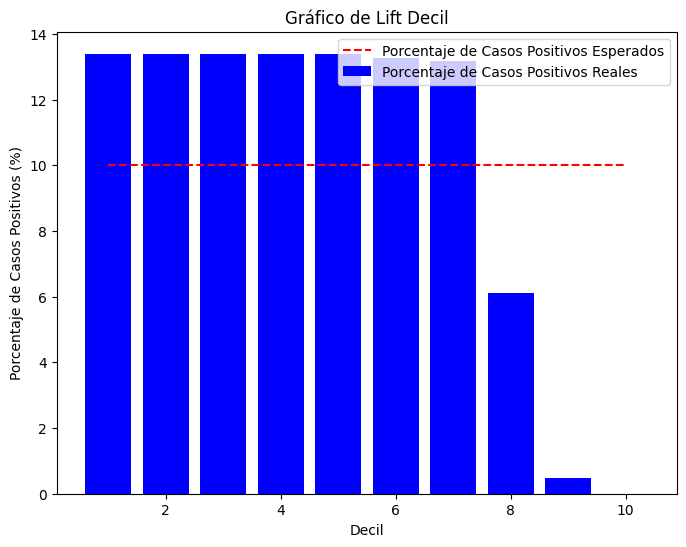

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Cargar el modelo desde Google Drive
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Ordena las etiquetas verdaderas y las probabilidades de predicción por probabilidades descendentes
sorted_indices = np.argsort(y_scores[:, 1])[::-1]
y_true_sorted = np.array(y_true)[sorted_indices]

# Divide los datos en deciles
num_deciles = 10
decile_size = len(y_true_sorted) // num_deciles

# Calcular el número total de casos positivos reales
total_positive_cases = np.sum(y_true_sorted)

# Calcular el porcentaje de casos positivos reales en cada decil
percentage_positive_cases_per_decile = [(cases / total_positive_cases) * 100 for cases in positive_cases_per_decile]

# Crear el gráfico de Lift Decil con barras en porcentaje
plt.figure(figsize=(8, 6))
plt.bar(range(1, num_deciles + 1), percentage_positive_cases_per_decile, label='Porcentaje de Casos Positivos Reales', color='blue')
plt.plot(range(1, num_deciles + 1), [total_positive_cases / (num_deciles * total_positive_cases) * 100] * num_deciles, linestyle='--', color='red', label='Porcentaje de Casos Positivos Esperados')
plt.xlabel('Decil')
plt.ylabel('Porcentaje de Casos Positivos (%)')
plt.title('Gráfico de Lift Decil')
plt.legend()
plt.show()


El grafico de Lift por deciles nos permite evaluar como se comporta nuestro modelo en diferentes deciles (valga la redundancia) y esto nos ayuda a determinar si nuestro modelo proporciona valor agregado en terminos de la deteccion de casos positivos  en comparacion con un enfoque meramente aleatorio. Cuanto mas alto este la deteccion de casos positivos en los primeros deciles mejor sera la capacidad del modelo para identificar casos positivos de manera eficiente.

En nuestro caso, nuestro modelo lo hace bien hasta el decil 7, lo cual es muy aceptado. Por convencion, un minimo de 3 deciles ya es aceptado.

## Pruebas con Bulk Uploading

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tabulate import tabulate

def get_predictions(test_folder, model):
    img_height, img_width = 180, 180  # Tamaño de las imágenes de entrada del modelo
    class_names = ['Notumor', 'Tumor'] # Nombres de las clases

    # Función para preprocesar una imagen
    def preprocess_image(image):
        image = cv2.imread(image)  # Leer la imagen
        image = cv2.resize(image, (img_width, img_height))  # Redimensionar la imagen al tamaño de entrada del modelo

        return image

    # Obtener la lista de archivos de imágenes en la carpeta de prueba
    image_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if
                   file.endswith((".bmp", ".gif", ".jpeg", ".jpg", ".png"))]

    for image_file in image_files:
        image = preprocess_image(image_file)
        image = np.expand_dims(image, axis=0)  # Agregar una dimensión adicional para el batch
        predictions = model.predict(image)
        scores = tf.nn.softmax(predictions)

        img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        classes = []
        probabilities = []
        for i, class_name in enumerate(class_names):
            class_index = i
            probability = scores[0][class_index] * 100
            classes.append(class_name)
            probabilities.append("%.3f" % probability)

        # Ordenar la tabla por la columna de probabilidades en orden descendente
        sorted_data = sorted(zip(classes, probabilities), key=lambda x: float(x[1]), reverse=True)
        sorted_classes, sorted_probabilities = zip(*sorted_data)

        data = {'Class': sorted_classes, 'Probability (%)': sorted_probabilities}
        table = tabulate(data, headers='keys', tablefmt='fancy_grid')
        print(table)
        print()

1/1 [==============================] - 0s 84ms/step


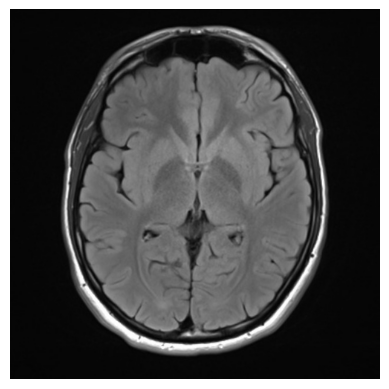

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.961 │
├─────────┼───────────────────┤
│ Tumor   │             0.039 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 21ms/step


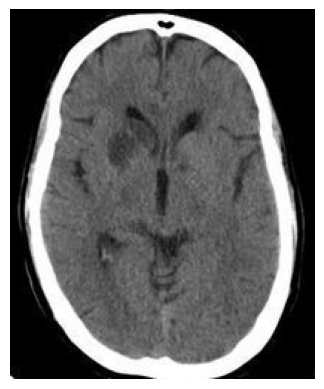

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            70.437 │
├─────────┼───────────────────┤
│ Tumor   │            29.563 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 31ms/step


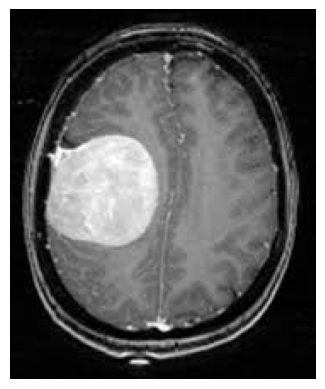

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.735 │
├─────────┼───────────────────┤
│ Tumor   │             0.265 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 35ms/step


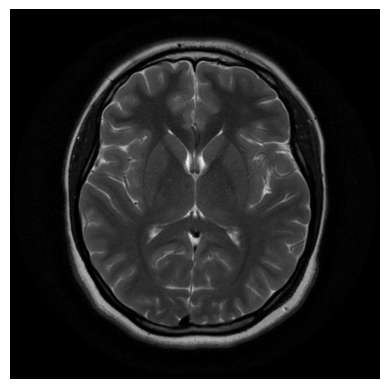

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.666 │
├─────────┼───────────────────┤
│ Tumor   │             0.334 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 41ms/step


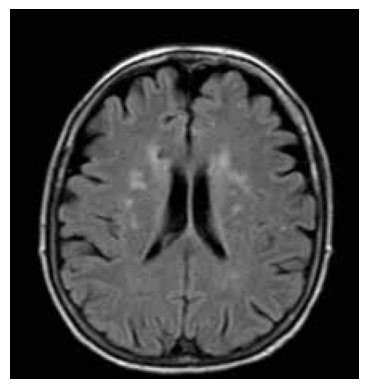

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.823 │
├─────────┼───────────────────┤
│ Tumor   │             0.177 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 32ms/step


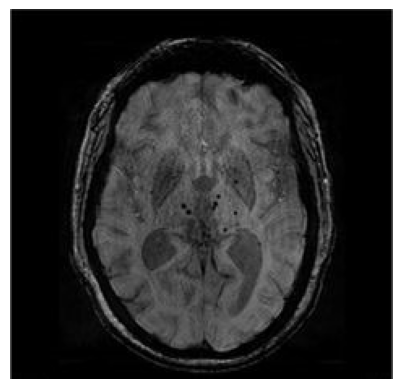

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.397 │
├─────────┼───────────────────┤
│ Tumor   │             0.603 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 29ms/step


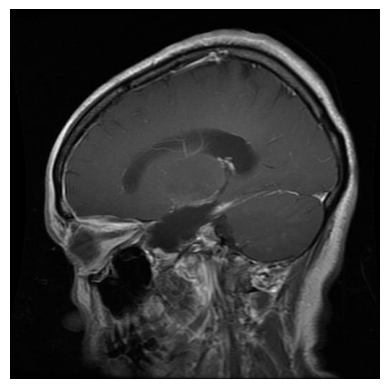

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Tumor   │            99.966 │
├─────────┼───────────────────┤
│ Notumor │             0.034 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 28ms/step


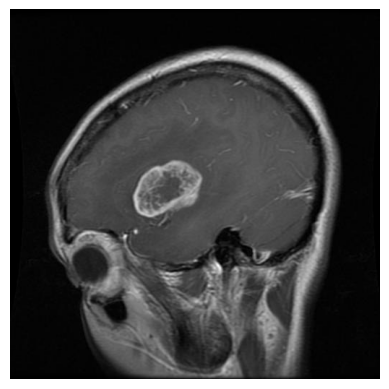

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Tumor   │               100 │
├─────────┼───────────────────┤
│ Notumor │                 0 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 35ms/step


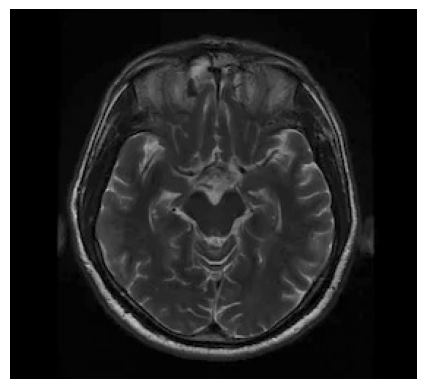

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            95.207 │
├─────────┼───────────────────┤
│ Tumor   │             4.793 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 30ms/step


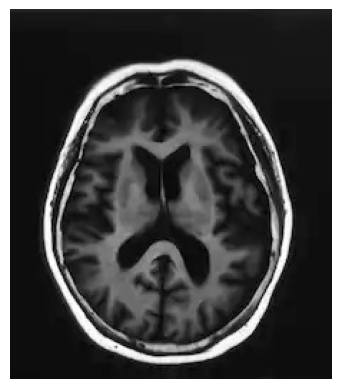

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            96.395 │
├─────────┼───────────────────┤
│ Tumor   │             3.605 │
╘═════════╧═══════════════════╛



In [ ]:
test_folder = '/content/drive/MyDrive/Patient File'
model = tf.keras.models.load_model('/content/TFM_CNNv_Bin.h5')

get_predictions(test_folder, model)
